# Troop 349 The Dice Game Simulation

Simulation of the _Troop 349 Dice Game_ to determine average play length in turns and the value of different winning point total choices.

This notebook can be run interactively via Binder!

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stephenhouser/Troop349-Dice-Game/master?filepath=Troop349_Dice_Game_Simulation.ipynb)

In [0]:
# Python imports for packages used later on.
import random
import itertools

import matplotlib.pyplot as plt
import numpy as np

## Customization
Here you can tweak what's on the die faces, how many dice are rolled for each turn, and how many dice are used to set the initial winning point total.

Only '349' has been extensively tested. Some values might perhaps make an unresolvable game! Adjust at your own risk.

In [0]:
# What's on the die faces
die_faces = (3, 4, 9)

# Number of dice rolled by players for their turn
n_dice = 3

# Number of dice used to determine winning point total
n_dice_win = 2

Some pre-computation to make our simulation go a bit quicker, or at least I think it will make it go quicker. Could just be premature optimization too.

* Precompute all the possible winning point totals.

* Precompute all the possible turn totals (all the combinations of dice and +/- based on the die faces and number of dice). Then we don't have to do the calculations at simulation time, we just look up the value that gets us closest to where we want to be.

* Precompute the maximum poss

In [0]:
# Pre-compute all the possible winning point totals 
# hint: it's fixed and all are equally likely (are they?)
all_win_combinations = list(itertools.product(die_faces, repeat=n_dice_win))
all_win_totals = tuple(map(lambda dice: int(str(dice[0]) + str(dice[1])), all_win_combinations))

In [0]:
# Pre-compute all the possible player rolls and their possible totals
# this is a 2D structure, 
#    one entry for each possible roll combination
#    then all the possible addition and subtraction combinations for the roll
def possible_roll_totals(dice):
  results = set()
  # ---
  results.add(- dice[0] - dice[1] - dice[2])
  # --+
  results.add(- dice[0] - dice[1] + dice[2])
  # -+-
  results.add(- dice[0] + dice[1] - dice[2])
  # -++
  results.add(- dice[0] + dice[1] + dice[2])
  # +--
  results.add(+ dice[0] - dice[1] - dice[2])
  # +-+
  results.add(+ dice[0] - dice[1] + dice[2])
  # ++-
  results.add(+ dice[0] + dice[1] - dice[2])
  # +++
  results.add(+ dice[0] + dice[1] + dice[2])
  return list(results)

all_roll_combinations = list(itertools.combinations_with_replacement(die_faces, n_dice))
all_roll_totals = {}
for dice in list(all_roll_combinations):
    all_roll_totals[dice] = tuple(possible_roll_totals(dice))


## Die Rolling

Here's the core function we use to roll the dice for each turn.

In [0]:
def roll_dice():
  """Simulate a roll of n_dice with die_faces on them and returns a list of the results."""
  return tuple(sorted(random.choices(die_faces, k=n_dice)))


## Intermediate Check
This is just a diagnostic intermediate check of the precomputations that we have done. Give them a look and make sure they seem to make sense at this point.

In [392]:
print(all_win_totals)
print(all_roll_totals)
print(roll_dice())
random.choice(all_win_totals)

(33, 34, 39, 43, 44, 49, 93, 94, 99)
{(3, 3, 3): (9, 3, -3, -9), (3, 3, 4): (2, 4, 10, -10, -4, -2), (3, 3, 9): (3, 9, 15, -15, -9, -3), (3, 4, 4): (3, 5, 11, -11, -5, -3), (3, 4, 9): (2, 8, 10, -16, 16, -10, -8, -2), (3, 9, 9): (3, -21, 15, -15, 21, -3), (4, 4, 4): (4, 12, -12, -4), (4, 4, 9): (1, 9, -17, 17, -9, -1), (4, 9, 9): (4, -22, 14, -14, 22, -4), (9, 9, 9): (9, 27, -27, -9)}
(4, 9, 9)


93

## Play A Game
This is the main function used to simulate one play of the game. It selects a winning point total, and tracks the number of turns needed to get there. If passed `True` then will print some diagnostic information to the console as it does it's work.

Returns a tuple of (number of turns played, the winning point total) which is used in our statistics computation later on.

In [0]:
def play_game(show_progress = False):
  """Simulate a game and reuturn the number of turns to win."""
  turns = 0
  current_points = 0
  win_points = random.choice(all_win_totals)
  
  if show_progress:
    print('GAME: win = {} points'.format(win_points))
  while current_points != win_points:
    dice = roll_dice()
    if show_progress:
      print('TURN {}: points = {}, roll = {}, '.format(turns, current_points, dice), end='')
    
    # Optimize when current points is far below win_points
    if current_points + sum(dice) < win_points:
      turn_points = sum(dice)
      if show_progress:
        print('best = {}'.format(turn_points))
    else:
      target_choice = win_points - current_points
      possible_combinations = all_roll_totals[dice]
      turn_points = min(possible_combinations, key=lambda x:abs(x-target_choice))
      if show_progress:
        print('possible = {}, best = {}'.format(possible_combinations, turn_points))

    current_points += turn_points
    turns += 1
      
  return (turns, win_points)
    

Simulate a sample game and show the progress.

In [394]:
play_game(True)

GAME: win = 93 points
TURN 0: points = 0, roll = (3, 4, 9), best = 16
TURN 1: points = 16, roll = (3, 4, 9), best = 16
TURN 2: points = 32, roll = (3, 9, 9), best = 21
TURN 3: points = 53, roll = (3, 9, 9), best = 21
TURN 4: points = 74, roll = (3, 3, 9), best = 15
TURN 5: points = 89, roll = (3, 3, 9), possible = (3, 9, 15, -15, -9, -3), best = 3
TURN 6: points = 92, roll = (9, 9, 9), possible = (9, 27, -27, -9), best = 9
TURN 7: points = 101, roll = (3, 3, 4), possible = (2, 4, 10, -10, -4, -2), best = -10
TURN 8: points = 91, roll = (3, 4, 9), possible = (2, 8, 10, -16, 16, -10, -8, -2), best = 2


(9, 93)

## Simulate a Bunch of Games

Now we are ready to simulate a whole bunch of games. How many is a whole bunch? Here it's 250,000 because things start running out of memory (or CPU time) when I adjust it to much more. Even when you do, the results don't vary that much, so it's _good enough_ for my purposes.

In [0]:
# Play a bunch of games and accumulate the number of turns and the win_points..
games = []
for n in range(250000):
  games.append(play_game())
  
# Lots of output for each game  
print(games)

## How Many Turns to Win?

Here we plot a histogram of the number of turns it took to finish each of the games we simulated. This gives us an idea of how long games will take.

Included in the histogram is the median (the number of turns for the middle-most game), the mean (the average number of turns needed), and the 95th percentile (the number of turns in which 95% of all simulated games were completed before).

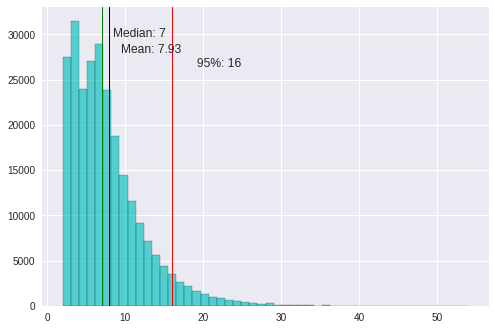

In [396]:
# Plot simple histogram of number of turns needed to win
np_games = np.array(games)

x = np_games[:,0]
#y = np_games[:,1]

n, bins, patches = plt.hist(x, bins=50, color='c', edgecolor='k', alpha=0.65)
_, max_ = plt.ylim()

median_turns = np.median(x)
_ = plt.axvline(median_turns, color='g', linewidth=1)
_ = plt.text(median_turns + median_turns/5, max_ - max_/10, 'Median: {:.0f}'.format(median_turns))

mean_turns = x.mean()
_ = plt.axvline(mean_turns, color='k', linewidth=1)
_ = plt.text(mean_turns + mean_turns/5, max_ - max_/6.5, 'Mean: {:.2f}'.format(mean_turns))

ninety_percent_turns = np.percentile(x, 95) 
_ = plt.axvline(ninety_percent_turns, color='r', linewidth=1)
_ = plt.text(ninety_percent_turns + ninety_percent_turns/5, max_ - max_/5, '95%: {:.0f}'.format(ninety_percent_turns))

## Winning Points Compared to Mean Turns to Win

Compare the number of turns on average it takes to win a game with different winning point totals. This tells us how best to choose the winning point total from the inital die roll. E.g. is it better to choose `39` or `93`? Which will allow us to win faster than our opponent?


win points=33, n_games=27653, median turns=6.32
win points=34, n_games=27706, median turns=6.50
win points=39, n_games=27709, median turns=6.79
win points=43, n_games=27778, median turns=6.84
win points=44, n_games=27484, median turns=7.04
win points=49, n_games=27940, median turns=7.30
win points=93, n_games=28322, median turns=10.05
win points=94, n_games=27599, median turns=10.07
win points=99, n_games=27809, median turns=10.42


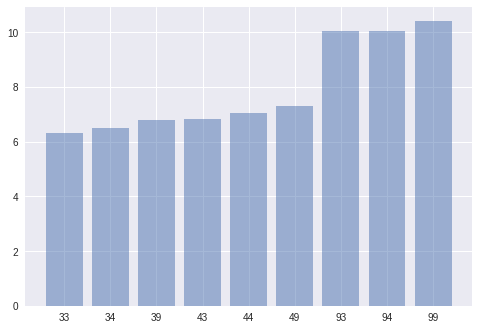

In [397]:
# Where we will accumulate the mean number of turns to play a game 
# with each winning point total
mean_turns = []

# Loop for each winning point (these are discrete and precomputed above)
for win_total in all_win_totals:
    # filter for only games with this winning point total
    games_wt = list(filter(lambda x: x[1] == win_total, games))
    
    # make a numpy array and select only the turns to play
    np_turns = np.array(games_wt)[:,0]
    
    # append to our collection array for later plotting
    mean_turns.append(np.mean(np_turns))
    
    # print some status details of our work
    print("win points={}, n_games={}, median turns={:.2f}".format(win_total, len(np_turns), np.mean(np_turns)))

# Plot the mean turns for each winning point total
y_pos = np.arange(len(all_win_totals)) 
plt.bar(y_pos, mean_turns, align='center', alpha=0.5)
plt.xticks(y_pos, list(all_win_totals)) 
plt.show()    